<a href="https://colab.research.google.com/github/saayanbiswas/Autonomous-Car/blob/main/Behavioral_Cloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [59]:
datadir='/content/drive/MyDrive/Training DATA/'

In [73]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
import cv2
import pandas as pd
import random
import ntpath
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


In [61]:
columns=['center', 'left','right', 'steering', 'throttle','reverse', 'speed']
data=pd.read_csv(os.path.join (datadir, 'driving_log.csv'), names=columns)
pd.set_option('display.max_colwidth',-1)
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


,center,left,right,steering,throttle,reverse,speed
0,D:\Personal files\COLLEGE\AI PROJECT\car training data\IMG\center_2021_11_26_20_40_24_972.jpg,D:\Personal files\COLLEGE\AI PROJECT\car training data\IMG\left_2021_11_26_20_40_24_972.jpg,D:\Personal files\COLLEGE\AI PROJECT\car training data\IMG\right_2021_11_26_20_40_24_972.jpg,0.0,0.0,0.0,0.000070
1,D:\Personal files\COLLEGE\AI PROJECT\car training data\IMG\center_2021_11_26_20_40_25_072.jpg,D:\Personal files\COLLEGE\AI PROJECT\car training data\IMG\left_2021_11_26_20_40_25_072.jpg,D:\Personal files\COLLEGE\AI PROJECT\car training data\IMG\right_2021_11_26_20_40_25_072.jpg,0.0,0.0,0.0,0.000069
2,D:\Personal files\COLLEGE\AI PROJECT\car training data\IMG\center_2021_11_26_20_40_25_174.jpg,D:\Personal files\COLLEGE\AI PROJECT\car training data\IMG\left_2021_11_26_20_40_25_174.jpg,D:\Personal files\COLLEGE\AI PROJECT\car training data\IMG\right_2021_11_26_20_40_25_174.jpg,0.0,0.0,0.0,0.000069
3,D:\Personal files\COLLEGE\AI PROJECT\car training data\IMG\center_2021_11_26_20_40_25_276.jpg,D:\Personal files\COLLEGE\AI PROJECT\car training data\IMG\left_2021_11_26_20_40_25_276.jpg,D:\Personal files\COLLEGE\AI PROJECT\car training data\IMG\right_2021_11_26_20_40_25_276.jpg,0.0,0.0,0.0,0.000069
4,D:\Personal files\COLLEGE\AI PROJECT\car training data\IMG\center_2021_11_26_20_40_25_377.jpg,D:\Personal files\COLLEGE\AI PROJECT\car training data\IMG\left_2021_11_26_20_40_25_377.jpg,D:\Personal files\COLLEGE\AI PROJECT\car training data\IMG\right_2021_11_26_20_40_25_377.jpg,0.0,0.0,0.0,0.000069


In [62]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center']=data['center'].apply(path_leaf)
data['left']=data['left'].apply(path_leaf)
data['right']=data['right'].apply(path_leaf)
data.head()


,center,left,right,steering,throttle,reverse,speed
0,center_2021_11_26_20_40_24_972.jpg,left_2021_11_26_20_40_24_972.jpg,right_2021_11_26_20_40_24_972.jpg,0.0,0.0,0.0,0.000070
1,center_2021_11_26_20_40_25_072.jpg,left_2021_11_26_20_40_25_072.jpg,right_2021_11_26_20_40_25_072.jpg,0.0,0.0,0.0,0.000069
2,center_2021_11_26_20_40_25_174.jpg,left_2021_11_26_20_40_25_174.jpg,right_2021_11_26_20_40_25_174.jpg,0.0,0.0,0.0,0.000069
3,center_2021_11_26_20_40_25_276.jpg,left_2021_11_26_20_40_25_276.jpg,right_2021_11_26_20_40_25_276.jpg,0.0,0.0,0.0,0.000069
4,center_2021_11_26_20_40_25_377.jpg,left_2021_11_26_20_40_25_377.jpg,right_2021_11_26_20_40_25_377.jpg,0.0,0.0,0.0,0.000069


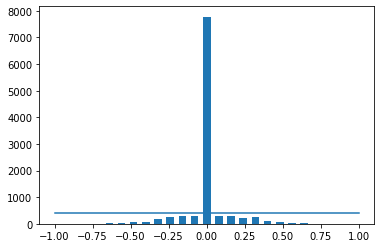

In [63]:
num_bins = 25
samples_per_bin=400
hist,bins=np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:])*0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])),(samples_per_bin, samples_per_bin))

total_data: 10201
removed: 7377
remaining: 2824


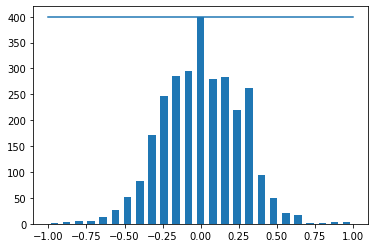

In [64]:
print('total_data:', len(data))
remove_list= []
for j in range(num_bins):
  list_= []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i]<=bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_= list_[samples_per_bin:]
  remove_list.extend(list_)
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))
hist,_ =np.histogram(data['steering'], num_bins)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])),(samples_per_bin, samples_per_bin))

In [65]:
def load_img_steering(datadir, df):
  image_path= []
  steering= []
  for i in range(len(data)):
    indexed_data= data.iloc[i]
    center, left, right= indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings  = load_img_steering(datadir + '/IMG', data)

 

In [66]:
X_train, X_valid, y_train, y_valid= train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples:{}\nValid Samples:{}'.format(len(X_train), len(X_valid)))

Training Samples:2259
Valid Samples:565


Text(0.5, 1.0, 'Validation set')

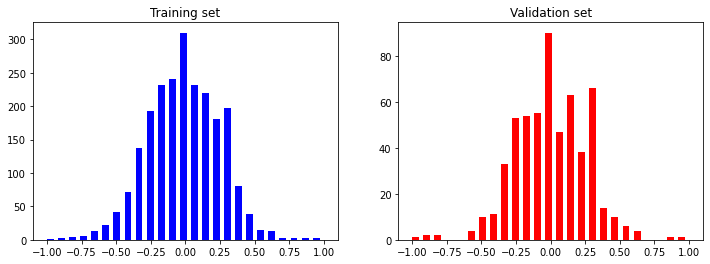

In [67]:
fig, axes= plt.subplots(1, 2, figsize=(12,4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red' )
axes[1].set_title('Validation set')

In [68]:
def img_preprocess(img):
  img= mpimg.imread(img)
  img= img[60:135, :, :]
  img= cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img=cv2.GaussianBlur(img, (3,3), 0)
  img=cv2.resize(img, (200,66))
  img=img/255
  return img

Text(0.5, 1.0, 'Preprocessed Image')

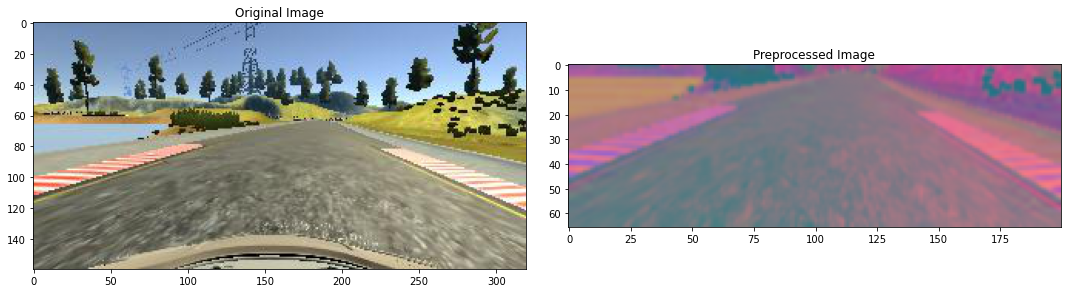

In [69]:
image = image_paths[150]
original_image= mpimg.imread(image)
preprocessed_image= img_preprocess(image)

fig, axs =plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [70]:
X_train=np.array(list(map(img_preprocess, X_train)))
X_valid=np.array(list(map(img_preprocess, X_valid)))

(2259, 66, 200, 3)


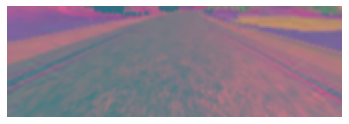

In [71]:
plt.imshow(X_train[random.randint(0,len(X_train)-1)])
plt.axis("off")
print(X_train.shape)

In [91]:
def nvidia_model():
  model=Sequential()
  model.add(Convolution2D(24, (5, 5), strides=(2,2), input_shape=(66,200,3), activation='elu'))
  model.add(Convolution2D(36, (5, 5), strides=(2,2), activation='elu'))
  model.add(Convolution2D(48, (5, 5), strides=(2,2), activation='elu'))
  model.add(Convolution2D(64, (3, 3), activation='elu'))
  model.add(Convolution2D(64, (3, 3), activation='elu'))
  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.5))

  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.5))

  model.add(Dense(10, activation='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(1))

  optimizer= Adam(lr=0.001)
  model.compile(loss='mse', optimizer=optimizer)
  return model


In [92]:
model= nvidia_model()
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 31, 98, 24)        1824      
                                                                 
 conv2d_12 (Conv2D)          (None, 14, 47, 36)        21636     
                                                                 
 conv2d_13 (Conv2D)          (None, 5, 22, 48)         43248     
                                                                 
 conv2d_14 (Conv2D)          (None, 3, 20, 64)         27712     
                                                                 
 conv2d_15 (Conv2D)          (None, 1, 18, 64)         36928     
                                                                 
 dropout_4 (Dropout)         (None, 1, 18, 64)         0         
                                                                 
 flatten_2 (Flatten)         (None, 1152)             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [93]:
history=model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), batch_size=100, verbose=1, shuffle=1)

Epoch 1/30
23/23 [==============================] - 2s 59ms/step - loss: 0.3675 - val_loss: 0.0721
Epoch 2/30
23/23 [==============================] - 1s 44ms/step - loss: 0.0923 - val_loss: 0.0515
Epoch 3/30
23/23 [==============================] - 1s 44ms/step - loss: 0.0740 - val_loss: 0.0469
Epoch 4/30
23/23 [==============================] - 1s 44ms/step - loss: 0.0636 - val_loss: 0.0430
Epoch 5/30
23/23 [==============================] - 1s 45ms/step - loss: 0.0639 - val_loss: 0.0402
Epoch 6/30
23/23 [==============================] - 1s 44ms/step - loss: 0.0546 - val_loss: 0.0392
Epoch 7/30
23/23 [==============================] - 1s 44ms/step - loss: 0.0549 - val_loss: 0.0363
Epoch 8/30
23/23 [==============================] - 1s 44ms/step - loss: 0.0523 - val_loss: 0.0357
Epoch 9/30
23/23 [==============================] - 1s 43ms/step - loss: 0.0512 - val_loss: 0.0349
Epoch 10/30
23/23 [==============================] - 1s 45ms/step - loss: 0.0465 - val_loss: 0.0340
Epoch 11/

Text(0.5, 0, 'Epoch')

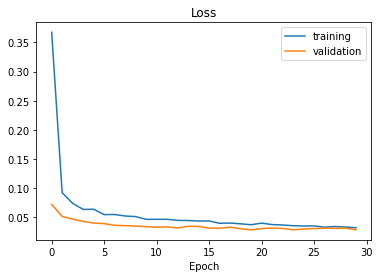

In [94]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [95]:
model.save('model.h5')

In [96]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>